In [11]:
## Libraries
import glob
from multiprocessing import cpu_count
import os
import random
import sys

## 3rd party
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

_path = ".."
if _path not in sys.path:
    sys.path.append(_path)
from lib.dataset import TextArtDataLoader, AlignCollate, ImageBatchSampler
from lib.config import Config
# from lib.preprocess import (pad_image, crop_edges_lr, )

%reload_ext autoreload
%autoreload 2

In [4]:
BATCH_SIZE = 4
# N_WORKERS = cpu_count() - 1
N_WORKERS = 0
CONFIG = Config()

In [5]:
train_dataset = TextArtDataLoader(CONFIG, mode='train')
val_dataset = TextArtDataLoader(CONFIG, mode='val')
test_dataset = TextArtDataLoader(CONFIG, mode='test')

train_align_collate = AlignCollate(CONFIG, 'train')
val_align_collate = AlignCollate(CONFIG, 'val')

train_batch_sampler = ImageBatchSampler(CONFIG, mode='train')
val_batch_sampler = ImageBatchSampler(CONFIG, mode='val')

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=train_align_collate,
                          sampler=train_batch_sampler,
                         )
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=val_align_collate,
                          sampler=val_batch_sampler
                         )
test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=None,
                         )

In [6]:
class InvNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

IMAGE: torch.Size([4, 3, 64, 64])
WV: torch.Size([4, 16, 768])
Fake WV: torch.Size([4, 16, 768])

WVs
religious/1.000 painting/1.000 baroque/1.000 historical/1.000 rococo/1.000 neoclassicism/1.000 historical/1.000 baroque/1.000 historical/1.000 neoclassicism/1.000 neoclassicism/1.000 painting/1.000 neoclassicism/1.000 baroque/1.000 rococo/1.000 apostl/1.000 

cityscape/1.000 symbolism/1.000 symbols/1.000 building/1.000 cityscape/1.000 building/1.000 symbols/1.000 square/1.000 square/1.000 maitreya/1.000 house/1.000 square/1.000 symbols/1.000 square/1.000 square/1.000 square/1.000 

icon/1.000 strawberry/1.000 sweet/1.000 adorable/1.000 strawberry/1.000 icon/1.000 icon/1.000 icon/1.000 scrap/1.000 sweet/1.000 strawberry/1.000 strawberry/1.000 sweet/1.000 adorable/1.000 strawberry/1.000 strawberry/1.000 

landscape/1.000 realism/1.000 expressionism/1.000 landscape/1.000 finland/1.000 finland/1.000 cliff/1.000 cliff/1.000 landscape/1.000 rock/1.000 cliff/1.000 rock/1.000 manneport/1.000 c

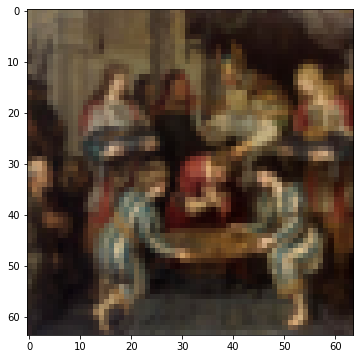

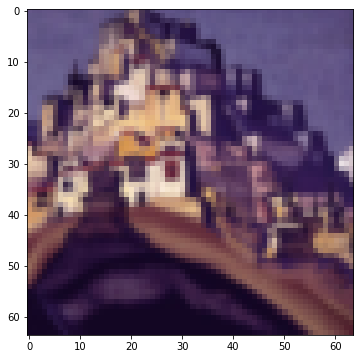

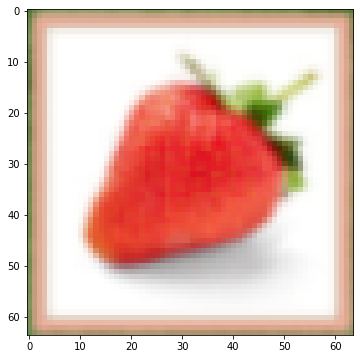

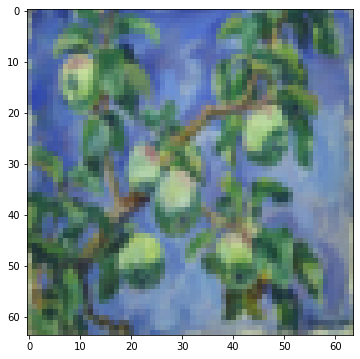

In [61]:
inv_normalize = InvNormalize(CONFIG.MEAN, CONFIG.STD)
for i, (images, wv_tensor, fake_wv_tensor) in enumerate(train_loader):
    print("IMAGE:", images.shape)
    print("WV:", wv_tensor.shape)
    print("Fake WV:", fake_wv_tensor.shape)
    
    print("\nWVs")
    for wvs in wv_tensor:
        for wv in wvs:
            wv = np.array(wv)
            word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(wv)[0]
            print("{}/{:.3f}".format(word, prob), end=' ')
        print('\n')
    
    print("-------------")
    print("\nFake WVs")
    for fake_wvs in fake_wv_tensor:
        for fake_wv in fake_wvs:
            fake_wv = np.array(fake_wv)
            fake_word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(fake_wv)[0]
            print("{}/{:.3f}".format(fake_word, prob), end=' ')
        print('\n')
    
    for image in images:
        image = inv_normalize(image)
        image = np.array(image)
        image = image.transpose(1, 2, 0)
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.show()
    break

In [54]:
from PIL import Image, ImageDraw, ImageFont
def words2image(text_list, n_column=1):
    config = Config()

    w = config.IMAGE_SIZE_WIDTH
    h = config.IMAGE_SIZE_HEIGHT

    img = Image.fromarray(np.ones((h, w)))
    draw = ImageDraw.Draw(img)

    ## Look for fonts
    for font in config.FONTS:
        try:
            font = ImageFont.truetype(font, 9)
        except OSError:
            continue
    
    if n_column == 1:
        
        x0 = int(w * 0.001)
        y0 = int(h * 0.001)
        word_height = h // len(text_list)
        for i, text in enumerate(text_list):
            y = i * word_height + y0
            x = x0
            draw.text((x, y), text, 0, font=font)

    elif n_column == 2:
        
        x1 = int(w * 0.01)
        x2 = int(w * 0.51)
        y0 = int(h * 0.01)
        word_height = h // len(text_list) * 2
        for i, text in enumerate(text_list):
            y = (i // 2) * word_height + y0 if i % 2 == 0 else (i - 1) // 2 * word_height + y0
            x = x1 if i % 2 == 0 else x2
            draw.text((x, y), text, 0, font=font)
            
    else:
        print("'words2image': Column {} not implemented".format(n_column))
        raise NotImplemented

    return np.array(img.convert('RGB')) * 255

In [55]:
images_bag = []
for i, (fake_image, real_wvs) in enumerate(zip(images, wv_tensor)):
    words = []
    for real_wv in real_wvs:
        real_wv = np.array(real_wv)
        word, prob = train_dataset.word2vec_model.wv.similar_by_vector(real_wv)[0]
        words.append(word)

    fake_image = np.array(fake_image).transpose(1, 2, 0)
    word_image = words2image(words)
    
    images_bag.extend([word_image, fake_image])
    
images_bag = np.array(images_bag)
words = np.unique(words)

In [56]:
words

array(['buddhism', 'cliff', 'finland', 'himalayas', 'lahaul', 'landscape',
       'maitreya', 'symbolism'], dtype='<U9')

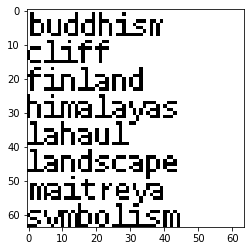

In [57]:
plt.imshow(words2image(words))

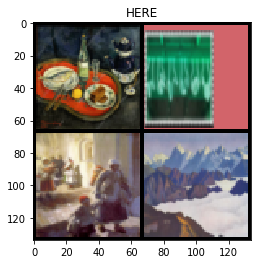

In [53]:
grid = make_grid(images, nrow=2).permute(1, 2, 0)
plt.title("HERE")
plt.imshow(grid)

In [2]:
words.extend(words)
text_list = words
image_shapes = (64, 64)
w, h = image_shapes

img = Image.fromarray(np.ones(image_shapes))
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("Lato-Medium.ttf", 10)

x1 = int(w * 0.1)
x2 = int(w * 0.6)
y0 = int(h * 0.01)
word_height = h // len(text_list) * 2
for i, text in enumerate(text_list):
    y = (i // 2) * word_height + y0 if i % 2 == 0 else (i - 1) // 2 * word_height + y0
    x = x1 if i % 2 == 0 else x2
    draw.text((x, y), text, 0, font=font)

img = np.array(img.convert('RGB')) * 255
plt.imshow(img)

NameError: name 'words' is not defined

In [ ]:
grid_pil = Image.fromarray(np.array(grid * 255, dtype=np.uint8))

In [ ]:
grid = make_grid(torch.Tensor(images_bag.transpose(0, 3, 1, 2)), nrow=4).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(grid)

In [ ]:
plt.imshow(words2image(words), cmap='gray')

In [ ]:
words.extend(words)

In [ ]:
words